# Reliability - Proof of Concept on a simulated dataset
In this notebook I show how we can study the reliability problem.


Recall that reliability is not focused on the overrall accuracy of a model
on a test set, it is rather focused on assessing how much reliable is
a prediction on a new unseen example (**Can we trust this prediction?**) .


Recall also that a "reliable" system should satisfy two principles:

- the local density principle: "how much my new example is similar
to instances of the training set?"
- the global (?) density principle: "how is my model accurate on the most similar examples of the 
training set?"

In [3]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np

First step: generate a simulated datasets with two classes
 drawn from a Gaussian distribution

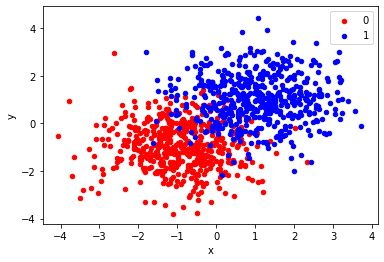

In [2]:
centers = [[-1, -1], [1, 1]]
X, y = make_blobs(n_samples=1000, centers=centers,
                  n_features=2, random_state=1,
                  )
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

Now I simulate the fact the fact that the available training set is not representative 
of the entire population, by sampling a subset of the two classes which are "biased"

In [6]:
# Removing instances from the center
# Selecting points between -1 1 in both x and y
iX = np.where((df.x>=-1) & (df.x <=1))